In [ ]:
import kagglehub
nazmul0087_ct_kidney_dataset_normal_cyst_tumor_and_stone_path = kagglehub.dataset_download('nazmul0087/ct-kidney-dataset-normal-cyst-tumor-and-stone')

print('Data source import complete.')


In [ ]:
import warnings
warnings.filterwarnings('ignore')

import os
os.environ['TF_CPP_MIN_LOG_LEVEL']='3'

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import albumentations as A
from albumentations.pytorch import ToTensorV2
from kerastuner import Hyperband
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.layers import Rescaling
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
from tensorflow.keras.callbacks import ReduceLROnPlateau,EarlyStopping,ModelCheckpoint
from tensorflow.keras import models
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import to_categorical

from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy('mixed_float16')

In [ ]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy()

print("REPLICAS: ", strategy.num_replicas_in_sync)

In [ ]:
path='/kaggle/input/ct-kidney-dataset-normal-cyst-tumor-and-stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone'

classes=['Cyst','Normal','Stone','Tumor']

train,val=tf.keras.utils.image_dataset_from_directory(path,
                                            label_mode='int',
                                            class_names=classes,
                                            image_size=(224,224),
                                            seed=6,
                                            validation_split=0.1,
                                            subset='both',
                                            batch_size=None)

In [ ]:
x_train=[]
y_train=[]
for x,y in train:
    x_train.append(x)
    y_train.append(y.numpy())

In [ ]:
x_test=[]
y_test=[]
for x,y in val:
    x_test.append(x)
    y_test.append(y.numpy())

In [ ]:
x_train=np.array(x_train).astype('float32')
x_test=np.array(x_test).astype('float32')

y_train=np.array(y_train)
y_test=np.array(y_test)

mean=np.mean(x_train)
std=np.std(x_train)

X_train = (x_train-mean)/(std+1e-7)
X_test  = (x_test-mean) /(std+1e-7)
print(mean,std)

In [ ]:
print(f' x_train shape :{x_train.shape} y_train shape :{y_train.shape}\n x_test shape :{x_test.shape} y_test shape :{y_test.shape}')

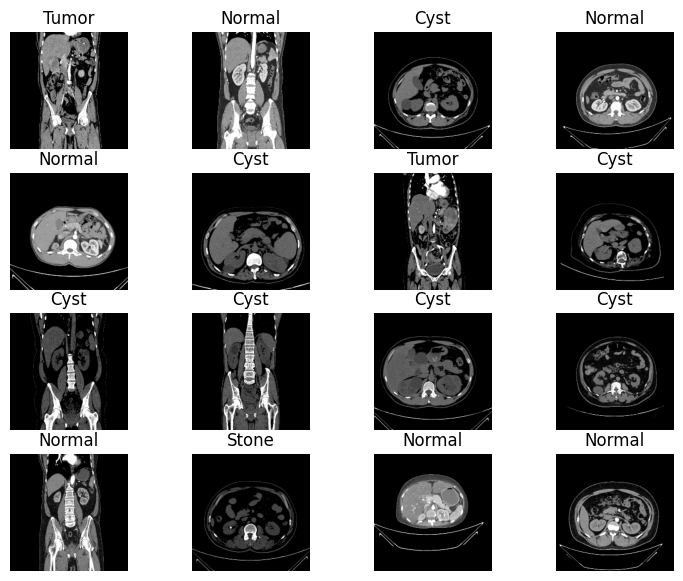

In [6]:
plt.figure(figsize=(9,7))
for i in range(16) :
    plt.subplot(4,4,i+1)
    plt.imshow(x_train[i]/255)
    plt.title(classes[y_train[i]])
    plt.axis('off')

In [ ]:
y_train=to_categorical(y_train)
y_test=to_categorical(y_test)

In [12]:
def build_augmentation_model(hp):
    augmentations = []

    if hp.Boolean('use_gamma', default=True):
        gamma_limit = hp.Float('gamma_limit', min_value=0.5, max_value=1.5, step=0.1, default=1.0)
        augmentations.append(A.RandomGamma(gamma_limit=(gamma_limit, 1.0/gamma_limit), p=hp.Float('gamma_p', 0.3, 0.7, 0.1)))

    if hp.Boolean('use_elastic', default=True):
        alpha = hp.Int('elastic_alpha', 30, 120, 15)
        sigma = hp.Int('elastic_sigma', 3, 7, 1)
        augmentations.append(A.ElasticTransform(alpha=alpha, sigma=sigma, p=hp.Float('elastic_p', 0.3, 0.7, 0.1)))

    if hp.Boolean('use_noise', default=True):
        noise_var = hp.Float('noise_var', 10.0, 50.0, 5.0)
        augmentations.append(A.GaussNoise(var_limit=(5.0, noise_var), p=hp.Float('noise_p', 0.3, 0.7, 0.1)))

    if hp.Boolean('use_blur', default=True):
        blur_limit = hp.Int('blur_limit', 3, 7, 2)
        augmentations.append(A.Blur(blur_limit=blur_limit, p=hp.Float('blur_p', 0.3, 0.7, 0.1)))

    if hp.Boolean('use_brightness_contrast', default=True):
        brightness = hp.Float('brightness', 0.1, 0.3, 0.05)
        contrast = hp.Float('contrast', 0.1, 0.3, 0.05)
        augmentations.append(A.RandomBrightnessContrast(
            brightness_limit=brightness,
            contrast_limit=contrast,
            p=hp.Float('brightness_contrast_p', 0.3, 0.7, 0.1)
        ))

    resize_height = hp.Choice('resize_height', [216, 224, 240, 256])
    resize_width = hp.Choice('resize_width', [216, 224, 240, 256])
    augmentations.append(A.Resize(height=resize_height, width=resize_width))

    augmentations.extend([
        A.HorizontalFlip(p=hp.Float('hflip_p', 0.3, 0.7, 0.1)),
        A.VerticalFlip(p=hp.Float('vflip_p', 0.3, 0.7, 0.1)),
        A.Normalize(mean=mean, std=std),
    ])

    transform = A.Compose(augmentations)

    base_model = tf.keras.applications.EfficientNetV2B0(
        input_shape=(resize_height, resize_width, 3),
        include_top=False,
        weights='imagenet'
    )
    base_model.trainable = False

    inputs = tf.keras.Input(shape=(resize_height, resize_width, 3))
    x = base_model(inputs, training=False)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dropout(hp.Float('dropout', 0.2, 0.5, 0.1))(x)
    outputs = tf.keras.layers.Dense(4, activation='softmax')(x)

    model = tf.keras.Model(inputs, outputs)

    model.compile(
        optimizer=tf.keras.optimizers.Adam(
            hp.Float('learning_rate', 1e-4, 1e-3, sampling='log')
        ),
        loss='categorical_crossentropy',
        metrics=['accuracy', tf.keras.metrics.AUC(multi_label=True)]
    )

    return model, transform

def albumentations_generator(x_data, y_data, transform, batch_size=32):
    indices = np.arange(len(x_data))
    while True:
        np.random.shuffle(indices)
        for i in range(0, len(indices), batch_size):
            batch_indices = indices[i:i+batch_size]
            batch_x = np.zeros((len(batch_indices), transform.transforms[0].height, transform.transforms[0].width, 3))

            for j, idx in enumerate(batch_indices):
                transformed = transform(image=x_data[idx])
                batch_x[j] = transformed['image']

            batch_y = y_data[batch_indices]
            yield batch_x, batch_y

class AugmentationTuner(Hyperband):
    def run_trial(self, trial, x_train, y_train, x_val, y_val, **kwargs):
        model, transform = self.hypermodel.build(trial.hyperparameters)

        train_gen = albumentations_generator(x_train, y_train, transform, batch_size=32)

        val_transform = A.Compose([
            A.Resize(height=transform.transforms[0].height, width=transform.transforms[0].width),
            A.Normalize(mean=mean, std=std)
        ])
        val_gen = albumentations_generator(x_val, y_val, val_transform, batch_size=32)

        callbacks = [
            tf.keras.callbacks.EarlyStopping(
                monitor='val_loss',
                patience=5,
                restore_best_weights=True
            )
        ]

        steps_per_epoch = len(x_train) // 32
        validation_steps = len(x_val) // 32

        history = model.fit(
            train_gen,
            steps_per_epoch=steps_per_epoch,
            validation_data=val_gen,
            validation_steps=validation_steps,
            epochs=20,
            callbacks=callbacks,
            verbose=1
        )

        return history.history['val_accuracy'][-1]


x_train_opt, x_val_opt, y_train_opt, y_val_opt = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42, stratify=y_train
)


tuner = AugmentationTuner(
    hypermodel=build_augmentation_model,
    objective='val_accuracy',
    max_epochs=20,
    factor=3,
    directory='hyperband_augmentation_search',
    project_name='kidney_classification'
)

tuner.search(
    x_train_opt, y_train_opt,
    x_val=x_val_opt, y_val=y_val_opt,
    verbose=1
)
best_hps = tuner.get_best_hyperparameters(1)[0]
print("Best augmentation hyperparameters:")
for param in best_hps.values:
    print(f"{param}: {best_hps.get(param)}")

best_augmentations = []

if best_hps.get('use_gamma'):
    gamma_limit = best_hps.get('gamma_limit')
    best_augmentations.append(A.RandomGamma(gamma_limit=(gamma_limit, 1.0/gamma_limit), p=best_hps.get('gamma_p')))

if best_hps.get('use_elastic'):
    best_augmentations.append(A.ElasticTransform(
        alpha=best_hps.get('elastic_alpha'),
        sigma=best_hps.get('elastic_sigma'),
        p=best_hps.get('elastic_p')
    ))

if best_hps.get('use_noise'):
    best_augmentations.append(A.GaussNoise(
        var_limit=(5.0, best_hps.get('noise_var')),
        p=best_hps.get('noise_p')
    ))

if best_hps.get('use_blur'):
    best_augmentations.append(A.Blur(
        blur_limit=best_hps.get('blur_limit'),
        p=best_hps.get('blur_p')
    ))

if best_hps.get('use_brightness_contrast'):
    best_augmentations.append(A.RandomBrightnessContrast(
        brightness_limit=best_hps.get('brightness'),
        contrast_limit=best_hps.get('contrast'),
        p=best_hps.get('brightness_contrast_p')
    ))

best_augmentations.extend([
    A.Resize(height=best_hps.get('resize_height'), width=best_hps.get('resize_width')),
    A.HorizontalFlip(p=best_hps.get('hflip_p')),
    A.VerticalFlip(p=best_hps.get('vflip_p')),
    A.Normalize(mean=mean, std=std),
])

best_transform = A.Compose(best_augmentations)
def apply_best_augmentations(x_data, y_data, transform, batch_size=32):
    dataset = tf.data.Dataset.from_generator(
        lambda: albumentations_generator(x_data, y_data, transform, batch_size),
        output_signature=(
            tf.TensorSpec(shape=(None, best_hps.get('resize_height'), best_hps.get('resize_width'), 3), dtype=tf.float32),
            tf.TensorSpec(shape=(None, 4), dtype=tf.float32)
        )
    )
    return dataset
train_dataset = apply_best_augmentations(X_train, y_train, best_transform)
val_transform = A.Compose([
    A.Resize(height=best_hps.get('resize_height'), width=best_hps.get('resize_width')),
    A.Normalize(mean=mean, std=std)
])
val_dataset = apply_best_augmentations(X_test, y_test, val_transform)


Best augmentation hyperparameters:
use_gamma: True
gamma_limit: 1.2
gamma_p: 0.5
use_elastic: True
elastic_alpha: 75
elastic_sigma: 5
elastic_p: 0.4
use_noise: True
noise_var: 20.0
noise_p: 0.3
use_blur: True
blur_limit: 5
blur_p: 0.3
use_brightness_contrast: True
brightness: 0.2
contrast: 0.15
brightness_contrast_p: 0.5
resize_height: 224
resize_width: 224
hflip_p: 0.5
vflip_p: 0.4
dropout: 0.3



In [ ]:
datagen=ImageDataGenerator(rotation_range=15,
                   width_shift_range=0.15,
                   brightness_range=[0.85,1.15],
                   height_shift_range=0.15,
                   shear_range=15,
                   zoom_range=0.1,
                   channel_shift_range=0.15
                  )

In [ ]:
base_model = tf.keras.applications.EfficientNetV2B0(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet'
)

base_model.trainable = False
inputs = tf.keras.Input(shape=(224, 224, 3))
x = base_model(inputs, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
outputs = tf.keras.layers.Dense(4, activation='softmax')(x)

model = tf.keras.Model(inputs, outputs)

model.summary()

In [8]:
cyst=3710
normal=5078
stone=1378
tumor=2284

no_of_classes=4

total=3710 + 5078 + 1378 + 2284
print('Total :', total)

cyst_weight=total/(no_of_classes * cyst)
print(f'cyst_weight : {cyst_weight:.4f}')

normal_weight=total/(no_of_classes * normal)
print(f'normal_weight : {normal_weight:.4f}')

stone_weight=total/(no_of_classes * stone)
print(f'stone_weight : {stone_weight:.4f}')

tumor_weight=total/(no_of_classes * tumor)
print(f'tumor_weight : {tumor_weight:.4f}')


Total : 12450
cyst_weight : 0.8389
normal_weight : 0.6129
stone_weight : 2.2587
tumor_weight : 1.3627


In [9]:
reduce_lr=ReduceLROnPlateau(factor=0.5,
                            patience=6,)

early_stopping=EarlyStopping(patience=10,
                             restore_best_weights=True,
                             monitor='val_loss')

checkpoint = ModelCheckpoint(
    filepath='/kaggle/working/kidney_model.keras',
    monitor='val_loss',
    save_best_only=True,
    mode='min',
    verbose=0)

model.compile(optimizer=tf.keras.optimizers.Adam(0.0005),
              loss='categorical_crossentropy',
              metrics=['accuracy',
              tf.keras.metrics.AUC(multi_label=True)])

history=model.fit(datagen.flow(x_train,y_train),
          validation_data=(x_test,y_test),
          epochs=200,
          batch_size=32,
          callbacks=[reduce_lr,early_stopping, checkpoint],
          verbose=1,
          class_weight={'0':cyst_weight,
                        '1':normal_weight,
                        '2':stone_weight,
                        '3':tumor_weight})


Epoch 1/200
  1/351 ━━━━━━━━━━━━━━━━━━━━ 5:05:56 52s/step - accuracy: 0.0938 - auc: 0.4119 - loss: 1.5480
I0000 00:00:1724026812.543093     149 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
351/351 ━━━━━━━━━━━━━━━━━━━━ 253s 573ms/step - accuracy: 0.5687 - auc: 0.7469 - loss: 1.0451 - val_accuracy: 0.7709 - val_auc: 0.9359 - val_loss: 0.6257 - learning_rate: 5.0000e-04
Epoch 2/200
351/351 ━━━━━━━━━━━━━━━━━━━━ 155s 432ms/step - accuracy: 0.7860 - auc: 0.9296 - loss: 0.6158 - val_accuracy: 0.8296 - val_auc: 0.9574 - val_loss: 0.5034 - learning_rate: 5.0000e-04
Epoch 3/200
351/351 ━━━━━━━━━━━━━━━━━━━━ 155s 431ms/step - accuracy: 0.8259 - auc: 0.9502 - loss: 0.5104 - val_accuracy: 0.8312 - val_auc: 0.9649 - val_loss: 0.4646 - learning_rate: 5.0000e-04
Epoch 4/200
351/351 ━━━━━━━━━━━━━━━━━━━━ 154s 430ms/step - accuracy: 0.8495 - auc: 0.9589 - loss: 0.4595 - val_accuracy: 0.8754 - val_auc: 0.9738 - val_loss: 0.3775 - lea

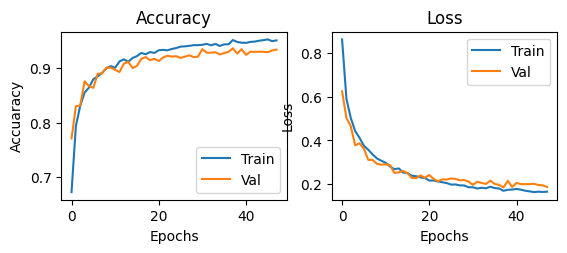

In [10]:
plt.subplot(2,2,1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy')
plt.legend(['Train','Val'])
plt.xlabel('Epochs')
plt.ylabel('Accuaracy')

plt.subplot(2,2,2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.legend(['Train','Val'])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

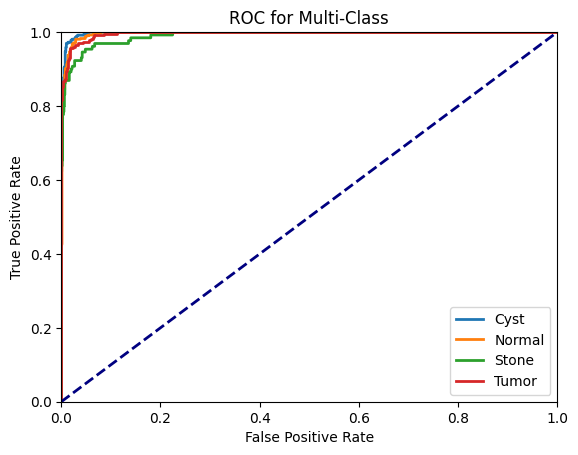

In [11]:
classes = [0, 1, 2, 3]
y_true_binary = label_binarize(y_test, classes=classes)

for i in range(len(classes)):
    fpr, tpr, _ = roc_curve(y_true_binary[:, i], y_scores[:, i])
    roc_auc = auc(fpr, tpr)

    plt.plot(fpr, tpr, lw=2, label=f'Class {classes[i]} (area = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC for Multi-Class')
plt.legend(['Cyst','Normal','Stone','Tumor'],loc="lower right")
plt.show()

In [ ]:
model.save('/kaggle/working//kidney_model.keras')

In [ ]:
kidney_model=tf.keras.models.load_model('/kaggle/working//kidney_model.keras')
kidney_model.compile(optimizer=tf.keras.optimizers.Adam(0.0005),
              loss='categorical_crossentropy',
              metrics=['accuracy',
              tf.keras.metrics.AUC(multi_label=True)])

test=tf.data.Dataset.from_tensor_slices((x_test,y_test)).batch(64)
kidney_model.evaluate(test)

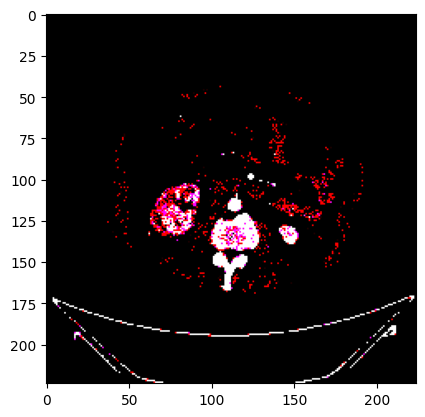

In [13]:
img_path = "/kaggle/input/ct-kidney-dataset-normal-cyst-tumor-and-stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/Tumor/Tumor- (1).jpg"
img = image.load_img(img_path, target_size=(224, 224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)
plt.imshow(img, cmap="jet")
plt.show()
gradcam = GradCAM(model, 'block5_conv1')

class_idx = 0
heatmap = gradcam.generate(x, class_idx)

heatmap = cv2.applyColorMap(np.uint8(255 * heatmap), cv2.COLORMAP_JET)
superimposed_img = heatmap * 0.35 + cv2.cvtColor(x[0], cv2.COLOR_RGB2BGR)
plt.imshow(superimposed_img, cmap="jet")
plt.show()
cv2.imwrite('/kaggle/input/ct-kidney-dataset-normal-cyst-tumor-and-stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/Tumor/Tumor- (1).jpg', superimposed_img)